# SN 1991bg Model

This notebook explores the 91bg model we have ported into SNCosmo.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import sncosmo
from astropy.table import Table

sys.path.insert(0, '../')
import snana_read as snread
from analysis_pipeline import SN91bgSource

print('Model Summary:')
print(SN91bgSource())


Model Summary:
class      : SN91bgSource
name       : 'sn91bg'
version    : color_interpolation
phases     : [-18, .., 100] days
wavelengths: [1000, .., 12000] Angstroms
parameters:
  x0 = 1.0
  x1 = 1.0
  c  = 0.55


In [2]:
# read raw SNANA data and transfer to SNcosmo format
lc_dir = '../snana_sims/snana_results/'
snc_fmt_dir = os.path.join(lc_dir, 'sncosmo_fmt')
if not os.path.exists(snc_fmt_dir):
    os.mkdir(snc_fmt_dir)

outpath = os.path.join(lc_dir, 'sncosmo_fmt')
snread.write_lc(1000, lc_dir, outpath)


91bg

reduced chi^2: 1.0440435316798609
sim_z: 0.08435
sim_t0: 53674.472656
sim_stretch: 0.803145
sim_color: 0.666517


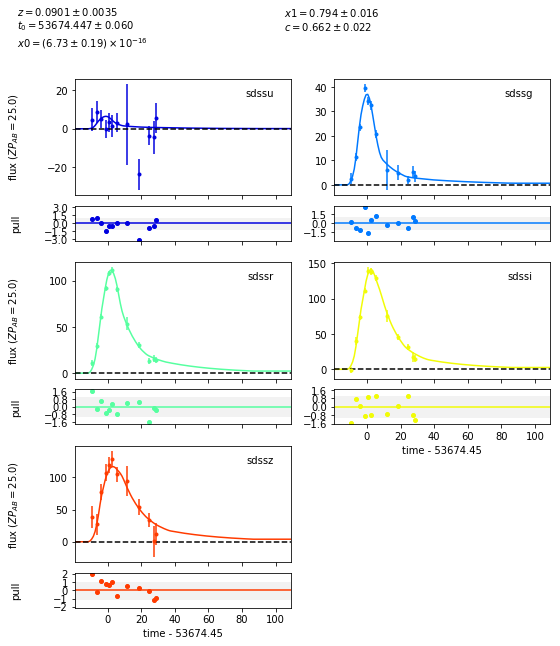

In [3]:
cid = 31
data = Table.read('../snana_sims/snana_results/sncosmo_fmt/sn91bg_{:05d}.csv'.format(cid))
meta = Table.read('../snana_sims/snana_results/sncosmo_fmt/meta.csv')
for par in ['cid', 'z', 't0', 'x1', 'c']:
    data.meta[par] = meta[par][cid - 1]

model = sncosmo.Model(source=SN91bgSource())
model.set(z=0.1)
result, fitted_model = sncosmo.fit_lc(
    data=data,
    model=model,
    vparam_names=['z', 't0', 'x0', 'x1', 'c'],
    bounds={'z': (0.01, 0.45), 'x1': (0.65, 1.25), 'c': (0, 1)},
    guess_z=False)

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
print('reduced chi^2:', result.chisq / result.ndof)
print('sim_z:', data.meta['z'])
print('sim_t0:', data.meta['t0'])
print('sim_stretch:', data.meta['x1'])
print('sim_color:', data.meta['c'])


Fitting with fixed simulation results

reduced chi^2: 1.0328586566538869
sim_z: 0.08435
sim_t0: 53674.472656
sim_stretch: 0.803145
sim_color: 0.666517


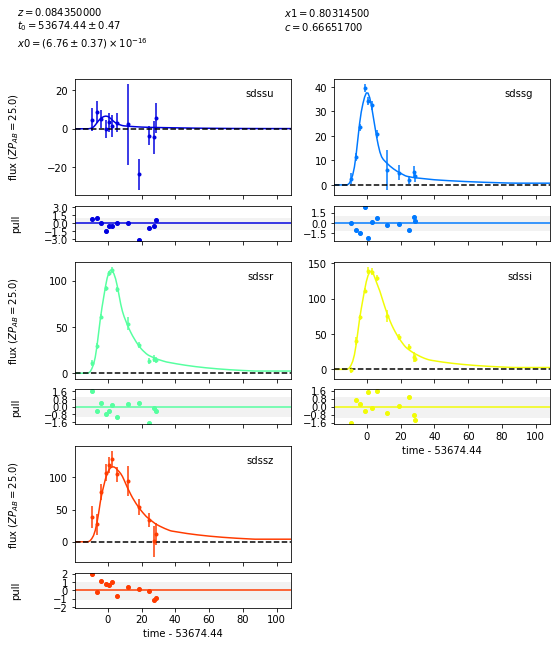

In [4]:
model.set(z=data.meta['z'], x1=data.meta['x1'], c=data.meta['c'])
result, fitted_model = sncosmo.fit_lc(
    data=data,
    model=model,
    vparam_names=['t0', 'x0'],
    bounds=None)

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
print('reduced chi^2:', result.chisq / result.ndof)
print('sim_z:', data.meta['z'])
print('sim_t0:', data.meta['t0'])
print('sim_stretch:', data.meta['x1'])
print('sim_color:', data.meta['c'])


# Output all fitting results

In [5]:
def fit_all(num, mod, band):
    """
    Run lc-fit for a series of SNe with both salt2 and 
    sn91bg model, output all the fitting results
    
    Args:
        num  (int): how many SN to fit
        mod  (str): Which model to use
        band (str): Which bands to fit, 'riz' for red, 
                      'ug' for blue and other strings for all
    """

    lc = range(num)
    sim_st = []
    sim_c = []
    sim_z = []
    fit_z = []
    fit_zerr = []
    fit_st = []
    fit_sterr = []
    fit_c = []
    fit_cerr = []
    chisq = []
    redchisq = []
    cid = []
    if mod == '91bg':
        model = sncosmo.Model(source=SN91bgSource())

    if mod == 'salt2':
        model = sncosmo.Model(source='salt2')

    for i in lc:
        try:
            meta = Table.read('../snana_sims/snana_results/sncosmo_fmt/meta.csv')
            table = Table.read(f'../snana_sims/snana_results/sncosmo_fmt/sn91bg_{i + 1:05d}.csv')

            #assert(len(table)/5.0>20)
            for par in ['z', 't0', 'x1', 'c']:
                table.meta[par] = meta[par][i]

            if band == 'ug':
                mask = (table['band'] == 'sdssu' + table['band'] == 'sdssg')
                data = table[mask]

            elif band == 'riz':
                mask = (table['band'] == 'sdssr' + table['band'] == 'sdssi' +
                        table['band'] == 'sdssz')
                data = table[mask]
            else:
                data = table
            #model.set(z=0.1) # flat prior for redshift, default is middle point of z bounds
            result, fitted_model = sncosmo.fit_lc(
                data=data, 
                model=model,
                vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                bounds={'z': (0.01, 0.45), 'x1': (0.65, 1.25), 'c': (0., 1.)})
            
            sim_st.append(data.meta['x1'])
            sim_c.append(data.meta['c'])
            sim_z.append(data.meta['z'])
            fit_st.append(round(result.parameters[3], 6))
            fit_sterr.append(round(result.errors['x1'], 6))
            fit_c.append(round(result.parameters[4], 6))
            fit_cerr.append(round(result.errors['c'], 6))
            fit_z.append(round(result.parameters[0], 6))
            fit_zerr.append(round(result.errors['z'], 6))
            chisq.append(round(result.chisq, 5))
            redchisq.append(round(result.chisq / result.ndof, 5))
            cid.append(i + 1)
            
        except:
            continue
            
    result = Table(
        data=[cid, sim_z, fit_z, fit_zerr, sim_st, fit_st, fit_sterr,
              sim_c, fit_c, fit_cerr, chisq, redchisq],
        names=['cid', 'sim_z', 'fit_z', 'fit_zerr', 'sim_st', 'fit_st',
               'fit_sterr', 'sim_c', 'fit_c', 'fit_cerr', 'chi^2', 'redchi^2'])

    return result


In [6]:
data = fit_all(100, '91bg', 'all')
#fit_all(1000,'91bg','ug')
#fit_all(1000,'91bg','riz')

data


cid,sim_z,fit_z,fit_zerr,sim_st,fit_st,fit_sterr,sim_c,fit_c,fit_cerr,chi^2,redchi^2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.22967,0.26118,0.013324,1.063945,0.94895,0.026146,0.452743,0.480018,0.021362,224.0822,1.14914
2,0.07114,0.083657,0.004115,1.008249,1.008238,0.015313,0.379536,0.427736,0.018856,66.9903,0.8932
3,0.05095,0.054437,0.002098,1.001499,1.004235,0.013589,0.715309,0.737657,0.016162,69.41576,1.15693
4,0.14484,0.142799,0.008971,1.003293,1.006368,0.033534,0.630328,0.636285,0.050442,67.41065,0.84263
5,0.06273,0.066959,0.001881,0.878921,0.873414,0.01292,0.444629,0.464859,0.016478,54.42497,0.98954
6,0.07555,0.127489,0.00955,0.963183,0.89573,0.047776,0.710921,0.605835,0.019867,20.98854,1.04943
7,0.14667,0.171564,0.003643,1.094911,1.079817,0.038978,0.422842,0.477011,0.034245,71.1728,1.01675
8,0.05527,0.063378,0.001092,1.055829,1.05069,0.013993,0.377175,0.399172,0.013784,87.33441,0.90035
9,0.178,0.191366,0.004894,1.135998,1.243496,0.058121,0.481698,0.496491,0.027668,85.53349,0.95037


# Comparison of simulated and fitted parameters

(0.5, 1.4)

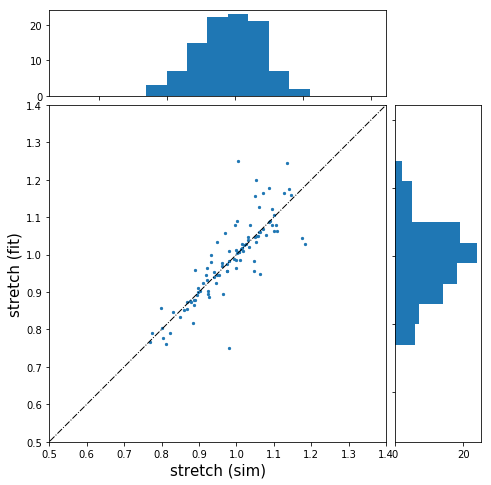

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 0.78, 0.78))
ax1 = fig.add_axes((0, 0.8, 0.78, 0.2))
ax2 = fig.add_axes((0.8, 0, 0.2, 0.78))
ax.scatter(data['sim_st'], data['fit_st'], s=5)
#ax.errorbar(data['sim_st'],data['fit_st'],yerr=data['fit_sterr'],fmt='.',elinewidth=1)
x_range = (0.5, 1.4)
y_range = (0.5, 1.4)
ax1.hist(data['sim_st'], bins=15, range=x_range)
ax2.hist(data['fit_st'], bins=15, range=y_range, orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (sim)', fontsize=15, fontweight='light')
ax.set_ylabel('stretch (fit)', fontsize=15, fontweight='light')
ax.plot(np.arange(0., 2., 0.1), np.arange(0., 2., 0.1), 'k-.', linewidth=1)
ax.set_xlim(x_range)
ax.set_ylim(y_range)


(-0.1, 1.1)

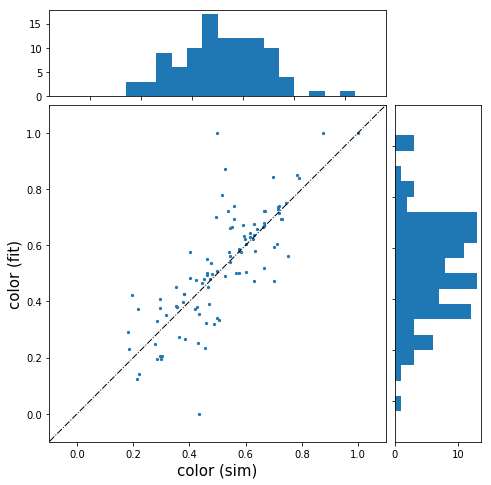

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 0.78, 0.78))
ax1 = fig.add_axes((0, 0.8, 0.78, 0.2))
ax2 = fig.add_axes((0.8, 0, 0.2, 0.78))
ax.scatter(data['sim_c'], data['fit_c'], s=5)
#ax.errorbar(data['sim_c'],data['fit_c'],yerr=data['fit_cerr'],fmt='.',elinewidth=1)
x_range = (-0.1, 1.1)
y_range = (-0.1, 1.1)
ax1.hist(data['sim_c'], bins=20, range=x_range)
ax2.hist(data['fit_c'], bins=20, orientation='horizontal', range=y_range)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('color (sim)', fontsize=15, fontweight='light')
ax.set_ylabel('color (fit)', fontsize=15, fontweight='light')
ax.plot(np.arange(-0.5, 1.2, 0.1), np.arange(-0.5, 1.2, 0.1), 'k-.',
        linewidth=1)
ax.set_xlim(x_range)
ax.set_ylim(y_range)


(0, 0.35)

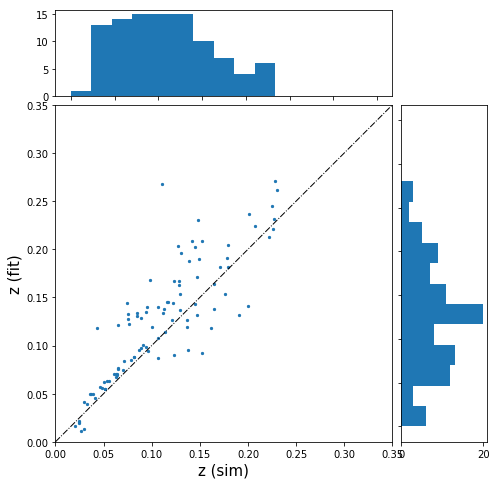

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 0.78, 0.78))
ax1 = fig.add_axes((0, 0.8, 0.78, 0.2))
ax2 = fig.add_axes((0.8, 0, 0.2, 0.78))
ax.scatter(data['sim_z'], data['fit_z'], s=5)
x_range = (0, 0.35)
y_range = (0, 0.35)
ax1.hist(data['sim_z'], bins=15, range=x_range)
ax2.hist(data['fit_z'], bins=15, range=y_range, orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('z (sim)', fontsize=15, fontweight='light')
ax.set_ylabel('z (fit)', fontsize=15, fontweight='light')
ax.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), 'k-.', linewidth=1)
ax.set_xlim(x_range)
ax.set_ylim(y_range)


Text(0.5, 1.0, 'SNANA simulation')

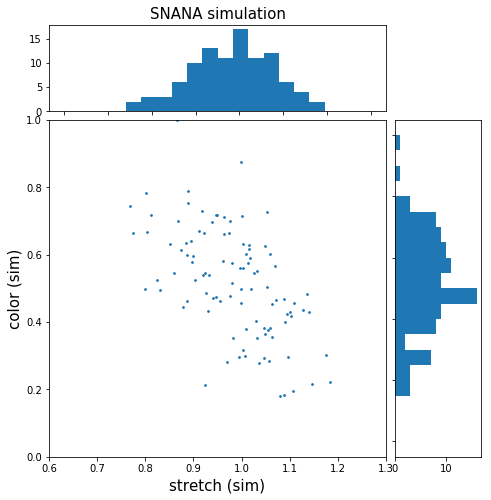

In [10]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_st'],data['sim_c'],s=3)
ax1.hist(data['sim_st'],bins=20,range=(0.6,1.3))
ax2.hist(data['sim_c'],bins=20,orientation='horizontal',range=(0,1))
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('color (sim)',fontsize=15,fontweight='light')
ax.set_xlim(0.6,1.3)
ax.set_ylim(0,1)
ax1.set_title('SNANA simulation',size=15)

Text(0.5, 1.0, 'fitted by model_1')

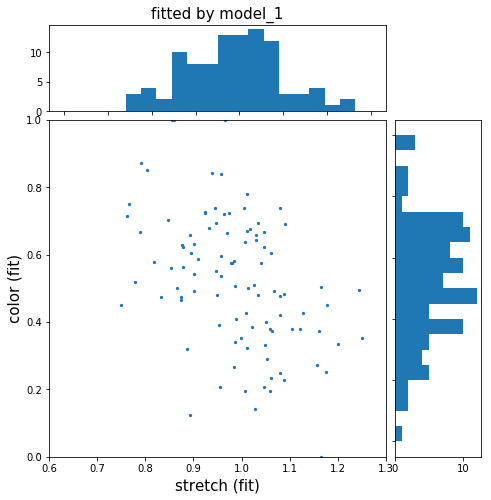

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 0.78, 0.78))
ax1 = fig.add_axes((0, 0.8, 0.78, 0.2))
ax2 = fig.add_axes((0.8, 0, 0.2, 0.78))
ax.scatter(data['fit_st'], data['fit_c'], s=5)
x_range = (0.6, 1.3)
y_range = (0, 1.)
ax1.hist(data['fit_st'], bins=20, range=x_range)
ax2.hist(data['fit_c'], bins=20, orientation='horizontal', range=y_range)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (fit)', fontsize=15, fontweight='light')
ax.set_ylabel('color (fit)', fontsize=15, fontweight='light')
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax1.set_title('fitted by model_1', size=15)
